# **LoanGuard: Model Training** 🚀

## **Objective**
This notebook focuses on building and evaluating machine learning models for **loan default prediction** using Lending Club data. The goal is to create a robust model that can accurately classify borrowers into **"Fully Paid"** and **"Charged Off"** categories, helping lenders make informed decisions.

## **Models to be Implemented**
- ✔️ **Baseline Models**: Logistic Regression, Naive Bayes, K-Nearest Neighbors (KNN)
- ✔️ **Tree-Based Models**: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
- ✔️ **Artificial Neural Network (ANN)**: Deep learning-based approach for capturing complex patterns
- ✔️ **Stacking Ensemble**: Combining multiple models for better predictive power

## **Expected Outcome**
By the end of this notebook, we aim to have a **high-performing loan default prediction model** that balances **accuracy, precision, and recall**, ensuring minimal false negatives (misclassified defaulters).

---

### 1. **Loading Libs**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, 
    confusion_matrix, precision_score, recall_score, f1_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### 2. **Load and Preprocess Data**

In [2]:
# Load train and test data
df_train = pd.read_csv('../data/processed/train.csv')
df_test = pd.read_csv('../data/processed/test.csv')

In [3]:
def encode_target(df):
    """Encode loan_status: Fully Paid -> 0, Charged Off -> 1"""
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
    return df

In [4]:
df_train = encode_target(df_train)
df_test = encode_target(df_test)

In [5]:
# Define features and target
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Define Model Evaluation Function

In [7]:
def evaluate_model(model_name, y_test, y_pred):
    print(f"\n📊 {model_name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

### 4. Model training

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [9]:
model_results = {}

In [10]:
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    evaluate_model(name, y_test, y_pred)
    model_results[name] = accuracy_score(y_test, y_pred)

Training Logistic Regression...
Time taken: 265.42 seconds

📊 Logistic Regression Performance:
Accuracy: 0.8892143256940876
Precision: 0.9397273379574265
Recall: 0.4625981161695447
F1 Score: 0.6199931620335061
ROC AUC Score: 0.7276971027375839
Confusion Matrix:
 [[104187    756]
 [ 13693  11787]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.94    104943
           1       0.94      0.46      0.62     25480

    accuracy                           0.89    130423
   macro avg       0.91      0.73      0.78    130423
weighted avg       0.89      0.89      0.87    130423

Training Naive Bayes...
Time taken: 0.49 seconds

📊 Naive Bayes Performance:
Accuracy: 0.8676537113852618
Precision: 0.7071633815597117
Recall: 0.5505494505494506
F1 Score: 0.6191054129796766
ROC AUC Score: 0.7475977958940139
Confusion Matrix:
 [[99134  5809]
 [11452 14028]]
Classification Report:
               precision    recall  f1-score   suppo

### 5. Save All Models

In [11]:
os.makedirs("../artifacts", exist_ok=True)
for name, model in models.items():
    filename = f"../artifacts/{name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved {name} to {filename}")

✅ Saved Logistic Regression to ../artifacts/Logistic_Regression.pkl
✅ Saved Naive Bayes to ../artifacts/Naive_Bayes.pkl
✅ Saved KNN to ../artifacts/KNN.pkl
✅ Saved Decision Tree to ../artifacts/Decision_Tree.pkl
✅ Saved Random Forest to ../artifacts/Random_Forest.pkl
✅ Saved XGBoost to ../artifacts/XGBoost.pkl
✅ Saved LightGBM to ../artifacts/LightGBM.pkl
✅ Saved CatBoost to ../artifacts/CatBoost.pkl


### 5. Model Comparison & Selection

In [14]:
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy
6             LightGBM  0.889728
0  Logistic Regression  0.889214
7             CatBoost  0.889061
4        Random Forest  0.889046
5              XGBoost  0.888402
2                  KNN  0.872193
1          Naive Bayes  0.867654
3        Decision Tree  0.829777


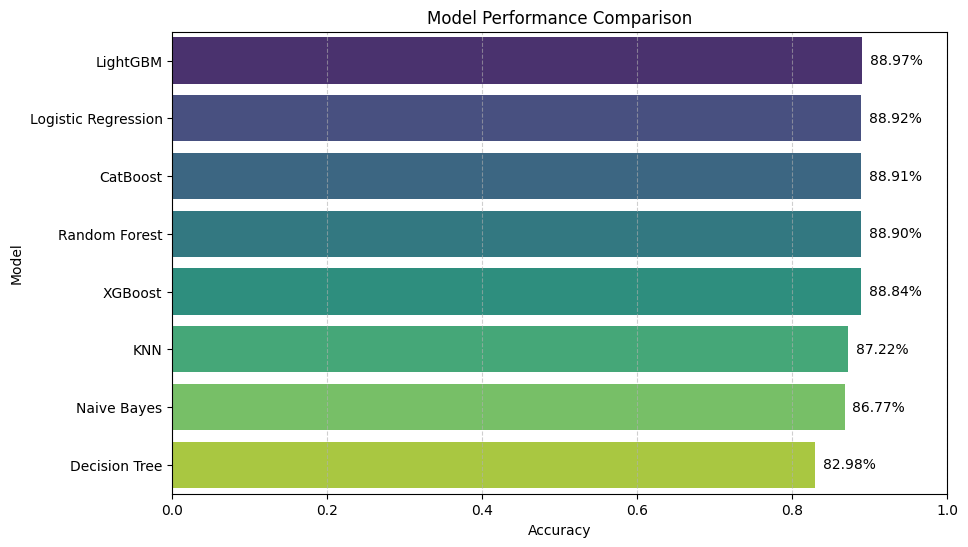

In [15]:
# 📊 Visualization of Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Accuracy"], y=results_df["Model"], palette="viridis", hue=results_df["Model"], legend=False)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the accuracy values on the bars
for index, value in enumerate(results_df["Accuracy"]):
    plt.text(value + 0.01, index, f"{value:.2%}", va="center")

plt.show()